In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchaudio

     |████████████████████████████████| 1.9 MB 4.3 MB/s 


Using device cuda
There are 35690 samples in the dataset.
torch.Size([1, 128, 431]) 0 64486.wav
0.5414124727934966


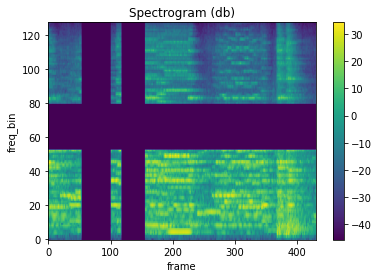

In [65]:
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import os
import torch
import matplotlib
import matplotlib.pyplot as plt
import librosa
import numpy as np
from random import seed
from random import random

class DCASE_Dataset(Dataset):

  def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device):
    self.annotations = pd.read_csv(annotations_file)
    self.audio_dir = audio_dir
    self.device = device
    self.transformation = transformation.to(self.device)
    self.target_sample_rate = target_sample_rate
    self.num_samples = num_samples

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    audio_sample_path = self._get_audio_sample_path(index)
    label = self._get_audio_sample_label(index)
    filename = self._get_audio_sample_filename(index)
    signal, sr = torchaudio.load(audio_sample_path) 
    signal = signal.to(self.device)
    signal = self._resample_if_necessary(signal, sr)
    signal = self._mix_down_if_necessary(signal)
    signal = self._cut_if_necessary(signal)
    signal = self._right_pad_if_necessary(signal)
    signal = self.transformation(signal) 
    return signal, label, filename

  def _cut_if_necessary(self, signal):
      if signal.shape[1] > self.num_samples:
          signal = signal[:, :self.num_samples]
      return signal

  def _right_pad_if_necessary(self, signal):
      length_signal = signal.shape[1]
      if length_signal < self.num_samples:
          num_missing_samples = self.num_samples - length_signal
          last_dim_padding = (0, num_missing_samples)
          signal = torch.nn.functional.pad(signal, last_dim_padding)
      return signal

  def _resample_if_necessary(self, signal, sr):
    if sr != self.target_sample_rate:
        resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).cuda()
        signal = resampler(signal)
    return signal

  def _mix_down_if_necessary(self, signal):
    if signal.shape[0] > 1: 
        signal = torch.mean(signal, dim=0, keepdim=True)
    return signal

  def _get_audio_sample_path(self, index):
    fold = f"{self.annotations.iloc[index, 1]}"
    path = os.path.join(self.audio_dir, fold, f"{self.annotations.iloc[index, 0]}.wav")
    return path

  def _get_audio_sample_label(self, index):
    return self.annotations.iloc[index, 2]

  def _get_audio_sample_filename(self, index):
    return f"{self.annotations.iloc[index, 0]}.wav"

if __name__ == "__main__":

  ANNOTATIONS_FILE = '/content/drive/My Drive/DCASE_Datasets/labels/combined_metadata.csv'
  AUDIO_DIR = '/content/drive/My Drive/DCASE_Datasets/audio/'
  SAMPLE_RATE = 22050
  DURATION = 10
  NUM_SAMPLES = 22050 * DURATION

  if torch.cuda.is_available():
    device = "cuda"
  else:
    device = "cpu"
  print(f"Using device {device}")

  mel_spectrogram = torchaudio.transforms.MelSpectrogram(
      sample_rate=SAMPLE_RATE,
      n_fft=1024,
      hop_length=512,
      n_mels=128
      )

  dcase_data = DCASE_Dataset(ANNOTATIONS_FILE, 
                             AUDIO_DIR, 
                             mel_spectrogram, 
                             SAMPLE_RATE,
                             NUM_SAMPLES,
                             device)

  print(f"There are {len(dcase_data)} samples in the dataset.")

  signal, label, filename = dcase_data[0]

  print(signal.shape, label, filename)

  def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    spec = spec.cpu()
    spec = spec[0,:,:]
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
      axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

  # seed(1)
  value = random()
  print(value)

  if value > 0.5:
    t1masking = torchaudio.transforms.TimeMasking(time_mask_param=80)
    t2masking = torchaudio.transforms.TimeMasking(time_mask_param=80)
    fmasking = torchaudio.transforms.FrequencyMasking(freq_mask_param=40)
    signal = t1masking(signal)
    signal = t2masking(signal)
    signal = fmasking(signal)

  plot_spectrogram(signal)


